In [12]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import os

In [13]:
# Training parameters
batch_size = 32
epochs = 200
num_classes = 10

In [14]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:
# Input image dimensions.
input_shape = x_train.shape[1:]
input_shape

(32, 32, 3)

In [16]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [17]:
# Subtracting pixel mean improves accuracy
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

In [18]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [19]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    return lr

In [21]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [22]:
n = 3
depth = n * 6 + 2

In [23]:
def resnet(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Data Augmentation

In [24]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)
    
datagen.fit(x_train)

# Compile the Model

In [26]:
model = resnet(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [28]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'ResNet'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [29]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Train the Model

In [31]:
h=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

Epoch 1/200
1563/1563 [==============================] - 74s 47ms/step - loss: 0.6903 - accuracy: 0.8253 - val_loss: 0.9550 - val_accuracy: 0.7558
Epoch 2/200
1563/1563 [==============================] - 74s 48ms/step - loss: 0.6783 - accuracy: 0.8302 - val_loss: 0.9319 - val_accuracy: 0.7552
Epoch 3/200
1563/1563 [==============================] - 73s 47ms/step - loss: 0.6586 - accuracy: 0.8372 - val_loss: 0.8667 - val_accuracy: 0.7786
Epoch 4/200
1563/1563 [==============================] - 74s 48ms/step - loss: 0.6497 - accuracy: 0.8406 - val_loss: 0.8737 - val_accuracy: 0.7788
Epoch 5/200
1563/1563 [==============================] - 74s 47ms/step - loss: 0.6388 - accuracy: 0.8448 - val_loss: 0.7559 - val_accuracy: 0.8108
Epoch 6/200
1563/1563 [==============================] - 75s 48ms/step - loss: 0.6377 - accuracy: 0.8468 - val_loss: 0.8977 - val_accuracy: 0.7722
Epoch 7/200
1563/1563 [==============================] - 74s 47ms/step - loss: 0.6268 - accuracy: 0.8501 - val_loss: 0

1563/1563 [==============================] - 69s 44ms/step - loss: 0.5061 - accuracy: 0.8979 - val_loss: 0.6684 - val_accuracy: 0.8509
Epoch 57/200
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5035 - accuracy: 0.8966 - val_loss: 0.7111 - val_accuracy: 0.8372
Epoch 58/200
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5027 - accuracy: 0.8987 - val_loss: 0.6028 - val_accuracy: 0.8701
Epoch 59/200
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5054 - accuracy: 0.8965 - val_loss: 0.7940 - val_accuracy: 0.8192
Epoch 60/200
1563/1563 [==============================] - 71s 45ms/step - loss: 0.5020 - accuracy: 0.8980 - val_loss: 0.8809 - val_accuracy: 0.8041
Epoch 61/200
1563/1563 [==============================] - 70s 45ms/step - loss: 0.5018 - accuracy: 0.9008 - val_loss: 0.7085 - val_accuracy: 0.8413
Epoch 62/200
1563/1563 [==============================] - 70s 45ms/step - loss: 0.5006 - accuracy: 0.8993 - val_loss: 0.6992 

1563/1563 [==============================] - 71s 46ms/step - loss: 0.4737 - accuracy: 0.9081 - val_loss: 0.8231 - val_accuracy: 0.8177
Epoch 112/200
1563/1563 [==============================] - 71s 45ms/step - loss: 0.4768 - accuracy: 0.9069 - val_loss: 0.7849 - val_accuracy: 0.8333
Epoch 113/200
1563/1563 [==============================] - 70s 45ms/step - loss: 0.4739 - accuracy: 0.9086 - val_loss: 0.7215 - val_accuracy: 0.8400
Epoch 114/200
1563/1563 [==============================] - 71s 45ms/step - loss: 0.4723 - accuracy: 0.9084 - val_loss: 0.6621 - val_accuracy: 0.8545
Epoch 115/200
1563/1563 [==============================] - 71s 45ms/step - loss: 0.4759 - accuracy: 0.9070 - val_loss: 0.6926 - val_accuracy: 0.8528
Epoch 116/200
1563/1563 [==============================] - 73s 47ms/step - loss: 0.4708 - accuracy: 0.9091 - val_loss: 0.7072 - val_accuracy: 0.8434
Epoch 117/200
1563/1563 [==============================] - 71s 46ms/step - loss: 0.4712 - accuracy: 0.9091 - val_loss: 0

1563/1563 [==============================] - 71s 45ms/step - loss: 0.4587 - accuracy: 0.9119 - val_loss: 0.7721 - val_accuracy: 0.8393
Epoch 167/200
1563/1563 [==============================] - 72s 46ms/step - loss: 0.4610 - accuracy: 0.9112 - val_loss: 0.6859 - val_accuracy: 0.8531
Epoch 168/200
1563/1563 [==============================] - 70s 45ms/step - loss: 0.4579 - accuracy: 0.9119 - val_loss: 1.1833 - val_accuracy: 0.7569
Epoch 169/200
1563/1563 [==============================] - 70s 45ms/step - loss: 0.4581 - accuracy: 0.9111 - val_loss: 0.8936 - val_accuracy: 0.8076
Epoch 170/200
1563/1563 [==============================] - 71s 45ms/step - loss: 0.4522 - accuracy: 0.9135 - val_loss: 0.6821 - val_accuracy: 0.8532
Epoch 171/200
1563/1563 [==============================] - 69s 44ms/step - loss: 0.4577 - accuracy: 0.9127 - val_loss: 0.6205 - val_accuracy: 0.8669
Epoch 172/200
1563/1563 [==============================] - 69s 44ms/step - loss: 0.4566 - accuracy: 0.9127 - val_loss: 0

# Loss

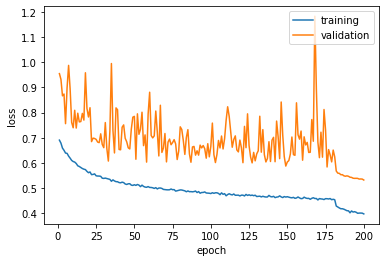

In [33]:
import matplotlib.pyplot as plt
epoch_nums = range(1, epochs+1)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

# Save the Model

In [34]:
fname = "weights-ResNetImageClassificationAug.hdf5"
model.save_weights(fname,overwrite=True)

# Load the Model

In [ ]:
fname = "weights-ResNetImageClassificationAug.hdf5"
model.load_weights(fname)

# Trained Model Score

In [35]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 263us/step
Test loss: 0.5315171558856964
Test accuracy: 0.8946999907493591
